## 1-step LSTM on multivariate time series to predict application counts in 8 month validation period

In [95]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [118]:
# Segment 1

train=pd.read_csv('./Data/train1.csv')
val=pd.read_csv('./Data/val1.csv')

In [96]:
# Segment 2

train=pd.read_csv('./Data/train2.csv')
val=pd.read_csv('./Data/val2.csv')

In [119]:
list(train.columns).index('ytrue')

0

In [120]:
train=train[['ytrue']+[c for c in train.columns if 'ytrue' not in c]]
val=val[['ytrue']+[c for c in val.columns if 'ytrue' not in c]]

In [121]:
train.columns

Index(['ytrue', 'y', 'sint', 'lint', 'cpi', 'Open', 'High', 'Low', 'Close',
       'sensex_missing',
       ...
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'f_absolute', 'f_angle'],
      dtype='object', length=129)

In [122]:
train.head()

,ytrue,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,f_absolute,f_angle
0,299.0,244.023810,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,0.0,244.023810,244.023810,0.000000,0.0,0.0,0.0,244.023810,1161.850979,-0.012882
1,0.0,58.238095,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,0.0,147.558150,143.389881,-4.168269,0.0,0.0,0.0,104.684524,216.975991,-0.113712
2,42.0,101.880952,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,0.0,131.146777,127.188937,-3.957840,0.0,0.0,0.0,102.743590,68.735975,-3.029528
3,23.0,300.619048,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,0.0,178.523818,181.934045,3.410227,0.0,0.0,0.0,236.309524,203.618392,0.086282
4,1530.0,714.142857,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,0.0,302.736082,326.533277,23.797195,0.0,0.0,0.0,556.181425,658.643535,0.036191


In [123]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [124]:
# Training set values

## * Note: I scale all features in range of [0,1].

values = train.values 

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [125]:
list(reframed.columns).index('var1(t)')

129

In [126]:
reframed=reframed.iloc[:,:130] # Seg 1
#reframed=reframed.iloc[:,:40] # Seg 2

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var121(t-1),var122(t-1),var123(t-1),var124(t-1),var125(t-1),var126(t-1),var127(t-1),var128(t-1),var129(t-1),var1(t)
1,0.013662,0.025923,0.501197,0.174963,0.171199,0.0,0.0,0.0,0.0,0.419355,...,0.024098,0.020287,0.336290,0.0,0.0,0.501347,0.021654,0.128595,0.500707,0.000000
2,0.000000,0.006187,0.501197,0.174963,0.171199,0.0,0.0,0.0,0.0,0.419355,...,0.003504,0.002813,0.334388,0.0,0.0,0.501347,0.005734,0.022839,0.484538,0.001919
3,0.001919,0.010823,0.501197,0.174963,0.171199,0.0,0.0,0.0,0.0,0.419355,...,0.000000,0.000000,0.334484,0.0,0.0,0.501347,0.005513,0.006248,0.016980,0.001051
4,0.001051,0.031935,0.501197,0.174963,0.171199,0.0,0.0,0.0,0.0,0.419355,...,0.010114,0.009506,0.337846,0.0,0.0,0.501347,0.020773,0.021344,0.516608,0.069911
5,0.069911,0.075864,0.501197,0.174963,0.171199,0.0,0.0,0.0,0.0,0.419355,...,0.036632,0.034615,0.347150,0.0,0.0,0.501347,0.057319,0.072273,0.508576,0.000000


In [127]:
# Validation set values

values_val = val.values 
values_val = values_val.astype('float32')
# normalize features
scaled_val = scaler.transform(values_val)
# frame as supervised learning
reframed_val = series_to_supervised(scaled_val, 1, 1)
reframed_val=reframed_val.iloc[:,:130] # Seg 1
list(reframed_val.columns).index('var1(t)')
#reframed_val=reframed_val.iloc[:,:40] # Seg 2

reframed_val.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var121(t-1),var122(t-1),var123(t-1),var124(t-1),var125(t-1),var126(t-1),var127(t-1),var128(t-1),var129(t-1),var1(t)
1,0.138771,0.127995,1.000000,0.901876,1.0,1.00000,1.00000,1.000000,1.000000,0.177419,...,0.229226,0.187132,0.336290,0.0,0.0,0.501347,0.131435,0.151571,0.502557,0.242586
2,0.242586,0.888486,1.000000,0.901876,1.0,1.00000,1.00000,1.000000,1.000000,0.177419,...,1.022774,0.860470,0.409585,0.0,0.0,0.501347,0.744883,0.908900,0.502836,0.244825
3,0.244825,1.024089,1.000000,0.901876,1.0,1.00000,1.00000,1.000000,1.000000,0.177419,...,1.384680,1.169355,0.447747,0.0,0.0,0.501347,0.987417,1.108862,0.502718,0.848983
4,0.848983,0.801547,1.334398,0.920635,1.0,1.17662,1.17663,1.180416,1.177669,0.419355,...,1.440073,1.206841,0.427856,0.0,0.0,0.501347,0.898615,0.809146,0.502820,0.011241
5,0.011241,0.633122,1.334398,0.920635,1.0,1.17662,1.17663,1.180416,1.177669,0.419355,...,1.394684,1.154122,0.386330,0.0,0.0,0.501347,0.748731,0.698895,0.502769,0.012794


In [128]:
# split into input and outputs
train_X, train_y = reframed.values[:, :-1], reframed.values[:, -1]
test_X, test_y = reframed_val.values[:, :-1], reframed_val.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(574, 1, 129) (574,) (250, 1, 129) (250,)


Train on 574 samples, validate on 250 samples
Epoch 1/200
 - 1s - loss: 0.0194 - val_loss: 0.0071
Epoch 2/200
 - 0s - loss: 0.0189 - val_loss: 0.0451
Epoch 3/200
 - 0s - loss: 0.0097 - val_loss: 0.0064
Epoch 4/200
 - 0s - loss: 0.0096 - val_loss: 0.0058
Epoch 5/200
 - 0s - loss: 0.0082 - val_loss: 0.0060
Epoch 6/200
 - 0s - loss: 0.0077 - val_loss: 0.0060
Epoch 7/200
 - 0s - loss: 0.0071 - val_loss: 0.0052
Epoch 8/200
 - 0s - loss: 0.0072 - val_loss: 0.0050
Epoch 9/200
 - 0s - loss: 0.0072 - val_loss: 0.0049
Epoch 10/200
 - 0s - loss: 0.0068 - val_loss: 0.0049
Epoch 11/200
 - 0s - loss: 0.0068 - val_loss: 0.0047
Epoch 12/200
 - 0s - loss: 0.0064 - val_loss: 0.0047
Epoch 13/200
 - 0s - loss: 0.0065 - val_loss: 0.0045
Epoch 14/200
 - 0s - loss: 0.0063 - val_loss: 0.0045
Epoch 15/200
 - 0s - loss: 0.0065 - val_loss: 0.0046
Epoch 16/200
 - 0s - loss: 0.0064 - val_loss: 0.0046
Epoch 17/200
 - 0s - loss: 0.0063 - val_loss: 0.0044
Epoch 18/200
 - 0s - loss: 0.0065 - val_loss: 0.0042
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0029 - val_loss: 0.0054
Epoch 155/200
 - 0s - loss: 0.0029 - val_loss: 0.0062
Epoch 156/200
 - 0s - loss: 0.0027 - val_loss: 0.0065
Epoch 157/200
 - 0s - loss: 0.0029 - val_loss: 0.0055
Epoch 158/200
 - 0s - loss: 0.0027 - val_loss: 0.0056
Epoch 159/200
 - 0s - loss: 0.0030 - val_loss: 0.0062
Epoch 160/200
 - 0s - loss: 0.0035 - val_loss: 0.0076
Epoch 161/200
 - 0s - loss: 0.0033 - val_loss: 0.0046
Epoch 162/200
 - 0s - loss: 0.0041 - val_loss: 0.0045
Epoch 163/200
 - 0s - loss: 0.0037 - val_loss: 0.0091
Epoch 164/200
 - 0s - loss: 0.0035 - val_loss: 0.0061
Epoch 165/200
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 166/200
 - 0s - loss: 0.0027 - val_loss: 0.0067
Epoch 167/200
 - 0s - loss: 0.0029 - val_loss: 0.0061
Epoch 168/200
 - 0s - loss: 0.0027 - val_loss: 0.0058
Epoch 169/200
 - 0s - loss: 0.0028 - val_loss: 0.0059
Epoch 170/200
 - 0s - loss: 0.0028 - val_loss: 0.0049
Epoch 171/200
 - 0s - loss: 0.0025 - val_loss: 0.0060
Epoch 172/200
 - 0s - loss: 

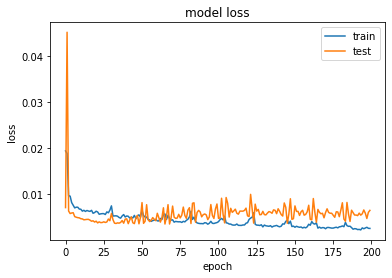

In [129]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [130]:
test_X.shape

(250, 1, 129)

In [131]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 129)) # For segment 1

#test_X = test_X.reshape((test_X.shape[0], 39)) # For segment 2
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -128:]), axis=1) # For segment 1
#inv_yhat = np.concatenate((yhat, test_X[:, -38:]), axis=1) # For segment 2

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -128:]), axis=1) # For segment 1
#inv_y = np.concatenate((test_y, test_X[:, -38:]), axis=1) # For segment 2

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1768.203


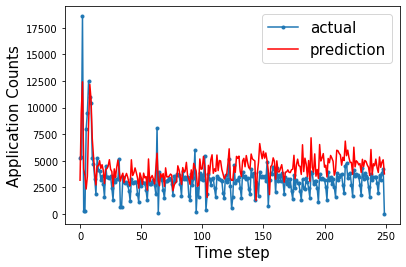

In [132]:
aa=[x for x in range(250)] # Seg 1
plt.plot(aa, inv_y[:250], marker='.', label="actual") # Seg 1
plt.plot(aa, inv_yhat[:250], 'r', label="prediction") # Seg 1


#aa=[x for x in range(240)] # Seg 2
#plt.plot(aa, inv_y[:240], marker='.', label="actual") # Seg 2
#plt.plot(aa, inv_yhat[:240], 'r', label="prediction") # Seg 2


plt.ylabel('Application Counts', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [133]:
def mape(ytrue,yhat):
    return np.mean(abs(ytrue-yhat)*100/ytrue)



In [134]:
print(mape(inv_y[:240],inv_yhat[:240]))

87.27255
